<a href="https://colab.research.google.com/github/shahin1009/ModelOrderReduction/blob/main/Lab_6_POD_NN_(trace).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

# **Lab 6 - Data-driven ROMs: the POD-NN approach**

When the PDE at hand involves nonlinear operators, implementing a POD-Galerkin ROM becomes highly nontrivial. In fact, suitable tricks, such as hyper-reduction, become necessary in order to ensure that the resulting ROM is sufficently fast (both in assembling the reduced system and in solving it). To overcome this difficulty, another approach is to switch from intrusive to nonintrusive methods, ultimately moving from physics-based ROMs towards data-driven ROMs.
</br>
</br>
We mentioned that methods based on POD rely on the following approximation

$$\mathbf{u}_{\boldsymbol{\mu}}\approx \mathbf{V}\mathbf{V}^\top\mathbf{u}_{\boldsymbol{\mu}},$$

where $\mathbf{V}\in\mathbb{R}^{N_h\times n}$ is the POD matrix. In particular, if we denote the POD coefficients by $\mathbf{c}_{\boldsymbol{\mu}}:=\mathbf{V}^\top\mathbf{u}_{\boldsymbol{\mu}}$, then the latter can be re-written as

$$\mathbf{u}_{\boldsymbol{\mu}}\approx \mathbf{V}\mathbf{c}_{\boldsymbol{\mu}}.$$

**In classical Reduced Basis methods**, such as POD-Galerkin, given $\boldsymbol{\mu}\in\mathbb{R}^{p}$, **the vector of POD coefficients is approximated by solving the projected PDE**, yielding $\tilde{\mathbf{c}}_{\boldsymbol{\mu}}\approx \mathbf{c}_{\boldsymbol{\mu}}$. For simple second order elliptic PDEs, this approximation is known to be optimal up to a constant (cf. Céa's Lemma).
</br>
</br>
**In contrast**, the idea behind data-driven techniques is to approximate the map
$$\mathbb{R}^{p}\ni\boldsymbol{\mu}\mapsto \mathbf{c}_{\boldsymbol{\mu}}\in\mathbb{R}^{n}$$
by fitting a suitable (nonlinear) regression model. To this end, a popular approach is to rely on deep neural networks: the resulting technique is typically referred to as **POD-NN**. The algorithm can be synthesized as follows:

- Collect FOM snapshots $\{\boldsymbol{\mu}_i, \mathbf{u}_{i}\}_{i=1}^{N}$, where $\mathbf{u}_i:=\mathbf{u}_{\boldsymbol{\mu}_i}$;

- Compute the POD basis $\mathbf{V}$ via SVD of the snapshots matrix

- Construct a new dataset $\{\boldsymbol{\mu}_i, \mathbf{c}_{i}\}_{i=1}^{N}$, consisting of parameter instances and POD coefficients, via projection $\mathbf{c}_{i}:=\mathbf{V}^\top\mathbf{u}_i$;

- Fit a neural network $\phi:\mathbb{R}^{p}\to\mathbb{R}^{n}$ so that $\phi(\boldsymbol{\mu}_i)\approx\mathbf{c}_{i}$;

- Define the ROM as the map $\boldsymbol{\mu}\mapsto \mathbf{V}\phi(\boldsymbol{\mu})$.

## Practical example

We consider a parametrized nonlinear diffusion (stationary regime), describing the temperature of a mechanical component (a rod), subject to external heat sources. To account for the properties of the material, and the high temperatures, we include a nonlinear term in the conductivity as well as a radiation term (modeling heat radiated outside of the rod).

Let $\Omega\subset\mathbb{R}^{2}$ denote the rod, and let $u:\Omega\to\mathbb[0,+\infty)$ be its temperature. The equations read as follows
</br></br>
$$\begin{cases}
-\nabla\cdot(\sigma(u)\nabla u) = f-\alpha u^{4} & \text{in}\;\Omega\\\\
-\sigma(u)\nabla u \cdot \boldsymbol{n} = 0 & \text{on}\;\partial\Omega\setminus\left(\cup_{i=1}^{3}\Gamma_{i}\right)\\\\
u = T_{i} & \text{on}\;\Gamma_{i}
\end{cases}$$
</br>
where $\sigma(u):=10^3 + e^{u/8}$, whereas $\Gamma_{1},\Gamma_{2},\Gamma_{3}$ are the inner left circle, inner right circle, and the "toothed region", respectively (see the plot below).

The model parameters are
$$\boldsymbol{\mu}:=[T_1, T_2, T_3, \log_{10}f, \log_{10}\alpha].$$
</br>
Here, we let $T_i\in[80, 120]$, $f\in[10^{1.5}, 10^5]$ and $\alpha\in[10^{-3.5}, 10^{-1.5}].$

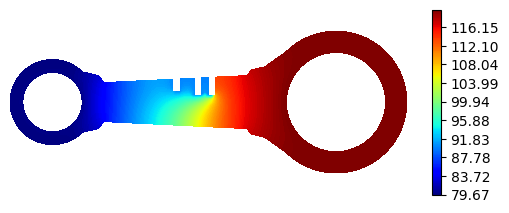

In [ ]:
from dlroms.testcases.rod import FOMsolver, Vh

mu_example = np.array([80, 120, 90, 2, -2])
u_example = FOMsolver(mu_example)
clc()

fe.plot(u_example, Vh, colorbar = True, shrink = 0.5)

The following piece of code will grant you access to $N$ FOM simulations, which can be readily downloaded and inspected. The data were sampled by picking random values of $\boldsymbol{\mu}$ uniformly in the parameter space $[80, 120]^3\times [1.5, 5] \times [-3.5, -1.5].$

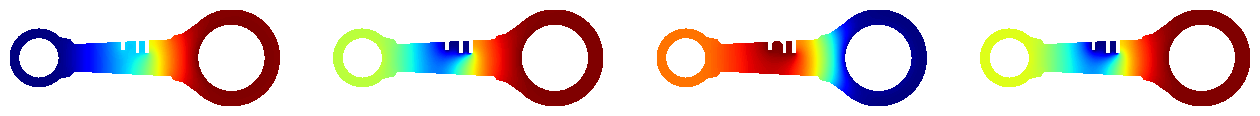

In [ ]:
import gdown

gdown.download(id = "1hxvCJDK9BQ23I7N4NurQDCFROQssj0dJ", output = "rod_data.npz", quiet = False)
clc()

data = np.load("rod_data.npz")
mu, u = data['mu'], data['u']

fe.multiplot(u[:4], (1, 4), Vh)

In [ ]:
u.shape

(500, 4347)

In [ ]:
mu.shape

(500, 5)

<mark>**Exercise 1**</mark></br>
Implement the POD-NN approach by relying on the data provided. To this end, split the data onto a training set and a test set using a 50:50 ratio.

In particular:

1. Study the decay of the singular values and compute a suitable POD basis;

2. Compute the average POD projection error (relative);

3. Compute the POD coefficients, thus assembling the data for the training of the neural network model;

4. Implement and train a suitable neural network architecture;

5. Compare the performances of the POD-NN surrogate with those of the FOM, discussing both accuracy and efficiency (to this end, notice the difference between computing a single solution vs computing 1000 independent solutions).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.linalg import svd
np.random.seed(42)

In [ ]:
# Ex 1.1
N = mu.shape[0]
N_train = 400
n_test = N - N_train
mu_train = mu[:N_train]
mu_test = mu[N_train:]
u_train = u[:N_train].T
u_test = u[N_train:].T





In [ ]:
X, s, Yt = svd(u_train, full_matrices = False)

In [ ]:
energy = np.cumsum(s**2) / np.sum(s**2)
r = np.argmax(energy >= 0.999999999999) + 1  # 99.99% energy
print("Number of modes: %d." % r)

Number of modes: 46.


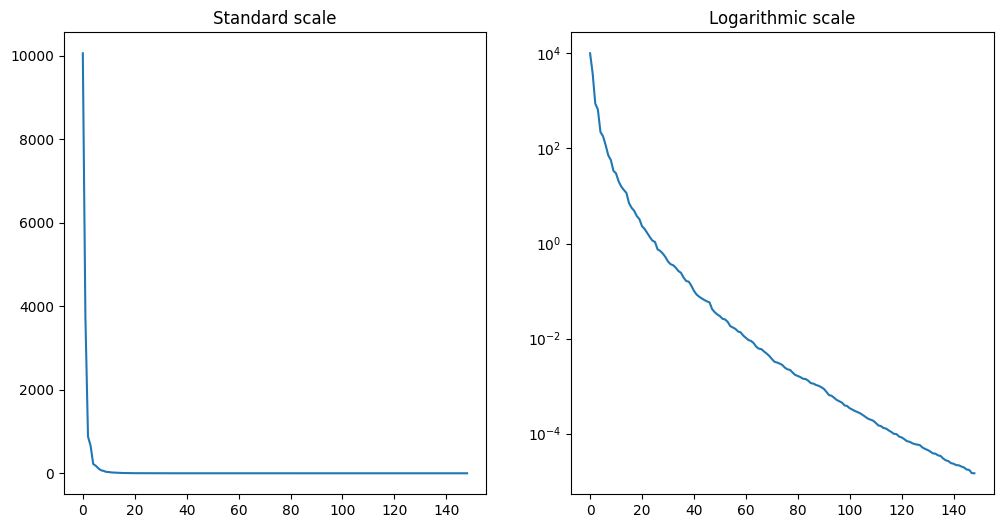

In [ ]:
r=150
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.plot(s[1:r])
plt.title("Standard scale")
plt.subplot(1,2,2)
plt.semilogy(s[1:r])
plt.title("Logarithmic scale")
plt.show()

In [ ]:
V = X[:, :r]
Uproj = V @ (V.T @ u_test)

errors = np.linalg.norm(u_test - Uproj, axis = 0) / np.linalg.norm(u_test, axis = 0)
print(errors.mean())

8.800601482132018e-09


In [ ]:
u_test.shape

(4347, 100)

In [ ]:
# Ex. 1.2
x_train = mu_train
y_train = (V.T @ u_train).T






In [ ]:
print(x_train.shape)
print(y_train.shape)

(400, 5)
(400, 150)


In [ ]:
from dlroms.dnns import Dense

In [ ]:
# Ex. 1.3.
network = Dense(5, 64,gelu) + Dense(64, 32,gelu) + Dense(32, r, activation = None)



# Embedding the architecture onto a trainable object
model = DFNN(network)

# Random initialization
model.He()





In [ ]:
from dlroms import dv
xdata = dv.tensor(x_train)
ydata = dv.tensor(y_train)

In [ ]:
def loss(true, pred):
    return (true-pred).pow(2).sum(axis = -1).mean()

def error(true, pred):
    return (true-pred).abs().sum(axis = -1).mean()

ntrain = int(N_train*0.7)
nvalid = int(ntrain*0.2)

model.train(xdata, ydata, ntrain = ntrain, nvalid = nvalid, epochs = 300, loss = loss, error = error)

		Train		Valid		Test
Epoch 300:	5.65e+01	7.16e+01	6.54e+01.

>> ETA: 0.15s.

Training complete. Elapsed time: 43.70 seconds.


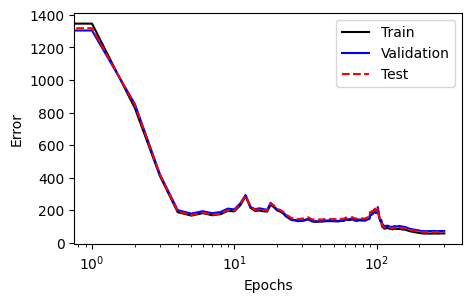

In [ ]:
plt.figure(figsize = (5, 3))
plt.semilogx(model.errors['Train'], '-k', label = 'Train')
plt.semilogx(model.errors['Validation'], 'b', label = 'Validation')
plt.semilogx(model.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
# Ex. 1.4.
# Note: phi should go from mu (p-dimensional) to c (n-dimensional)

model.freeze()




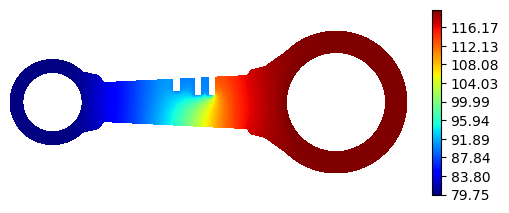

In [ ]:
fe.plot(V@model([80, 120, 90, 2, -2]), Vh, colorbar = True, shrink = 0.5)

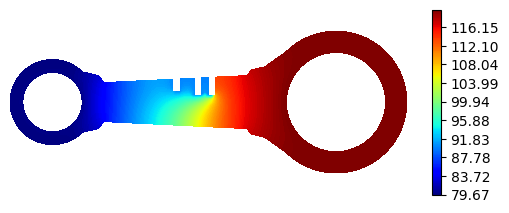

In [ ]:
fe.plot(u_example, Vh, colorbar = True, shrink = 0.5)

In [ ]:
def PODNN(mu_neww):
  c = model(mu_neww)
  return c@V.T

In [ ]:
mu[0]

array([101.95254016, 108.60757465, 104.11053504,   3.40709114,
        -2.3473096 ])

In [ ]:
mu[:10].shape

(10, 5)

In [ ]:
errors = np.linalg.norm(u - PODNN(mu), axis = 1) / np.linalg.norm(u, axis = 1)
print(num2p(errors.mean()))

0.31%


In [ ]:
errors.shape

(500,)

In [ ]:
# Ex. 1.5.
from time import perf_counter






**Note**

NN based ROMs become even more efficient when multiple calls are required (1000 calls are not 1000 times more expensive than a single call)! This is thanks to the high-efficiency of matrix-matrix multiplication.

<mark>**Exercise 2**</mark></br>
Let $T_2 = 90,\; T_3 = 115,\;f = 10^3,\;\alpha=10^{-3}.$ Which value of $T_1\in[80, 120]$ minimizes the variability of the temperature across the rod? Exploit the ROM to answer the question.
</br></br>
*Note:* here, we define the latter as

$$\text{Var}(\mathbf{u}):=\frac{1}{N_h}\sum_{j=1}^{N_h}|\mathrm{u}_j-\overline{\mathrm{u}}|^2,$$

where $\overline{\mathrm{u}}:=\frac{1}{N_h}\sum_{j=1}^{N_h}\mathrm{u}_j$.

In [ ]:
# Ex. 2.






